In [2]:
%load_ext autoreload
%autoreload 2
from ASD_Circuits import *
import numpy.ma as ma

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
def NormMat(ConnMat):
    New_Mat = []
    for STR in ConnMat.index.values:
        STR_i_weights = ConnMat.loc[STR, :].values
        normed = [w/sum(STR_i_weights) for w in STR_i_weights]
        New_Mat.append(normed)
    return pd.DataFrame(data = New_Mat, index=ConnMat.index.values, columns = ConnMat.columns.values)

def DeDirection(ConnMat):
    New_Symmtric_Mat = ConnMat.copy(deep=True)
    for i, STR_i in enumerate(ConnMat.index.values):
        for j, STR_j in enumerate(ConnMat.columns.values):
            New_Symmtric_Mat.loc[STR_i, STR_j] = ConnMat.loc[STR_i, STR_j] + ConnMat.loc[STR_j, STR_i]
            New_Symmtric_Mat.loc[STR_j, STR_i] = ConnMat.loc[STR_i, STR_j] + ConnMat.loc[STR_j, STR_i]
    return New_Symmtric_Mat

In [4]:
# Load Exp Bias
SparkMetaBias = pd.read_csv("dat/Jon_data/Spark_Final_ExpBias.csv")
SparkMetaBias.columns = ["STR", "EFFECT", "Rank", "NGene"]
SparkMetaBias = SparkMetaBias.set_index("STR")
STR2REG = STR2Region()

In [5]:
ConnFil="../dat/allen-mouse-conn/norm_density-max_ipsi_contra-pval_0.05-deg_min_1-by_weight.csv"
ConnMat = pd.read_csv(ConnFil, index_col=0) 
ConnMat_binary = ConnMat.mask(ConnMat>0, other = 1, inplace=False)

ConnMat_norm = NormMat(ConnMat)
ConnMat_binary_norm = NormMat(ConnMat_binary)

ConnMat_Symm = NormMat(DeDirection(ConnMat))
ConnMat_Symm_bin = NormMat(DeDirection(ConnMat_binary))

In [26]:
def process(BiasDF, ConnMat):
    diffG = DiffusionGraph(BiasDF, ConnMat)
    states = diffG.Diffuse2_vec(N = 20000, alpha=1e-3, beta=1e-3)
    BiasExchangeMat = np.zeros((213, 213))
    for i, src_node in enumerate(diffG.Matrix.index.values):
        for j, tgt_node in enumerate(diffG.Matrix.columns.values):
            t_heat = diffG.Matrix.loc[src_node, tgt_node] * states[-1, i]
            if t_heat > 0:
                BiasExchangeMat[i,j] = t_heat
    DF = pd.DataFrame(data=BiasExchangeMat, 
                      index=diffG.Matrix.index.values, columns=diffG.Matrix.columns.values)
    DF_mask = DF.mask(DF<0.04, other=0)
    hot_graph = LoadConnectome2(DF_mask)
    hot_graph_lg = hot_graph.clusters().giant()
    hot_graph_lg_nodes = hot_graph_lg.vs.select(_degree_gt=2)
    hot_subgraph = hot_graph_lg.subgraph(hot_graph_lg_nodes)
    return hot_subgraph

In [27]:
asd_hot = process(SparkMetaBias, ConnMat_norm)

In [28]:
print(len(asd_hot.vs["label"]))

49


In [16]:
InputDir = "dat/cont.sib.bias/ASD.sib.Spec.bias.{}.csv"
sib_hots = []
for i in range(10):
    df = pd.read_csv(InputDir.format(i), index_col="STR")
    sib_hots.append(process(df, ConnMat_norm))

In [17]:
for sib_hot in sib_hots:
    print(len(sib_hot.vs["label"]))

85
148
7
0
88
113
41
14
188
196


In [19]:
test = sib_hots[1]

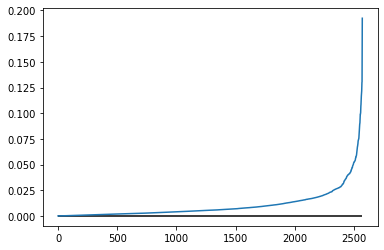

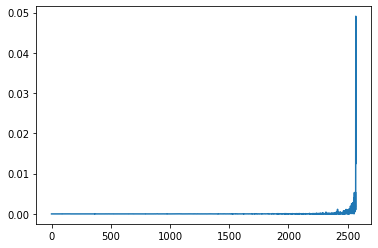

In [22]:
edges_rank = sorted([x for x in test.es["weight"] if x > 0])
plt.plot(np.arange(len(edges_rank)), edges_rank)
cut = 0.0001
plt.hlines(y = cut, xmin = 0, xmax = len(edges_rank), colors="black")
plt.show()
plt.plot(np.arange(len(edges_rank)-1), [edges_rank[i] - edges_rank[i-1] for i in range(1, len(edges_rank), 1)])
plt.show()